In [1]:
import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
BATCH_SIZE = 128
NUM_WORKERS = 3
MULT = 2
device = "cuda" if torch.cuda.is_available() else "cpu" 

print("Training on {}".format(device))

Training on cuda


In [3]:
torch_utils.seed_everything(43)

In [4]:
class MyData(Dataset):
    def __init__(self, X, y=None, transforms=None):
        self.X = X
        self.y = y
        self.transforms = transforms
        if y is not None:
            assert len(y)==len(X)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = np.array(self.X[idx,:], dtype='uint8').reshape(28,28)
        if self.transforms is not None:
            img = self.transforms(img)
        
        if self.y is not None:
            return img, self.y[idx]
        return img

In [5]:
train_transforms = txf.Compose([
    txf.ToPILImage(),
    txf.RandomRotation(10),
    txf.RandomAffine(degrees=7, translate=(0.3,0.3), scale=(0.8, 1.2), shear=7,),
    txf.ToTensor()
])

test_transforms = txf.Compose([
    txf.ToPILImage(),
    txf.FiveCrop(20),
    txf.Lambda(lambda crops: [txf.Resize(28)(crop) for crop in crops]),
    txf.Lambda(lambda crops: torch.stack([txf.ToTensor()(crop) for crop in crops]))
])

In [6]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
dig_df = pd.read_csv("./Dig-MNIST.csv")
sub_df = pd.read_csv("./sample_submission.csv")

In [7]:
target = train_df["label"]
train_df.drop("label", axis=1, inplace=True)
test_df.drop("id", axis=1, inplace=True)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df, target, stratify=target, random_state=947, test_size=0.1)

In [9]:
len(X_train), len(X_valid)

(54000, 6000)

In [10]:
dataset_train = MyData(train_df.to_numpy(), target.to_numpy(), train_transforms)
dataset_valid = MyData(X_valid.to_numpy(), y_valid.to_numpy(), test_transforms)
dataset_test = MyData(test_df.to_numpy(), transforms=test_transforms)
dataset_dig = MyData(dig_df.drop("label", axis=1).to_numpy(), dig_df["label"].to_numpy(), test_transforms)

In [11]:
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
dig_loader = DataLoader(dataset_dig, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

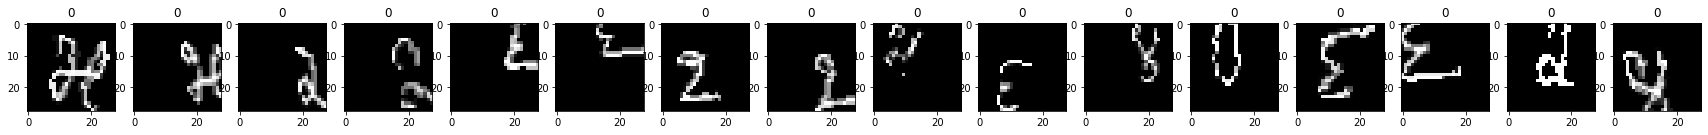

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=16, figsize=(30,4))

for batch in train_loader:
    for i in range(16):
        ax[i].set_title(batch[1][i].data.numpy().argmax())
        ax[i].imshow(batch[0][i, 0], cmap="gray")
    break

In [13]:
class SQENet(nn.Module):
    def __init__(self, n_classes, drop_prob=0.3):
        super(SQENet, self).__init__()
        
        self.conv1 = torch_utils.CNNLayer(1, MULT*32)
        self.conv2 = torch_utils.CNNLayer(MULT*32, MULT*32)
        
        self.conv3 = torch_utils.CNNLayer(MULT*32, MULT*64)
        self.conv4 = torch_utils.CNNLayer(MULT*64, MULT*64)
        
        self.conv5 = torch_utils.CNNLayer(MULT*64, MULT*128)
        self.conv6 = torch_utils.CNNLayer(MULT*128, MULT*128)
        
        self.se3 = torch_utils.Sq_Ex_Block(in_ch=256,r=8)
        
        self.fc1 = torch_utils.FCLayer(MULT*128*3*3, 256)
        self.fc2 = torch_utils.FCLayer(256, n_classes)
        
        
        self.maxpool = nn.MaxPool2d(2, 2) 
        self.drop = nn.Dropout2d(p=drop_prob)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.drop(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = self.conv5(x)
        x = self.conv6(x)
        
        x = self.se3(x)
        
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [14]:
# def cos_annealing_lr(init_lr, cur_epoch, epoch_per_cycle):
#     return init_lr*(np.cos(np.pi*cur_epoch/epoch_per_cycle)+1)/2

In [15]:
# n_cycle = 6
# init_lr = 0.05
# epochs_per_cycle = 15

# model = SQENet(10)
# # criterion = torch_utils.LabelSmoothingLoss(10, smoothing=0.15)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr = 1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True, patience=5)

In [16]:
# import time
# history = pd.DataFrame()
# digtory = pd.DataFrame()
# for cycle in range(n_cycle):
#     print("Learning Snapshot: {}".format(cycle+1))
    
#     for e in range(epochs_per_cycle):
#         torch_utils.clear_cuda()
#         curt = time.time() 
#         lr = cos_annealing_lr(init_lr, e, epochs_per_cycle)
#         optimizer.state_dict()["param_groups"][0]["lr"] = lr
#         print("Epoch: {} Learning rate: {}".format(e+1, lr))
        
#         train_loss, train_acc = torch_utils.train_classifier(model, optimizer, criterion, e+1, train_loader, device=device, print_interval=100)
#         valid_loss, valid_acc = torch_utils.test_classifier(model, criterion, device, valid_loader, tta=True)
        
#         cur_idx = epochs_per_cycle*cycle+e
        
#         history.loc[cur_idx, "lr"] = lr
#         history.loc[cur_idx, "train_loss"] = train_loss
#         history.loc[cur_idx, "train_acc"] = train_acc
#         history.loc[cur_idx, "valid_loss"] = valid_loss
#         history.loc[cur_idx, "valid_acc"] = valid_acc
#         print("Time Taken: {}\n\n".format(time.time()-curt))
    
#     dig_loss, dig_acc = torch_utils.test_classifier(model, criterion, device, dig_loader, tta=True)
#     digtory.loc[cycle, "dig_loss"] = dig_loss
#     digtory[cycle, "dig_acc"] = dig_acc
    
    
#     torch.save(model.state_dict(), "SQE_SNAPSHOT_"+str(cycle+1)+".pt")
        

In [58]:
# history["lr"].plot()

In [59]:
# history["train_acc"].plot()

In [60]:
# history["valid_acc"].plot()

In [61]:
# history["valid_loss"].plot()

In [62]:
# history["train_loss"].plot()

In [63]:
EPOCHS = 50

model = SQENet(10)
# criterion = torch_utils.LabelSmoothingLoss(10, smoothing=0.15)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True, patience=5)
model = model.apply(torch_utils.xavier_init)

In [64]:
# import time
# history = pd.DataFrame()

# for e in range(EPOCHS):
#     curt = time.time()
#     trl, tra = torch_utils.train_classifier(model, optimizer, criterion, e+1, train_loader, device, 100)
#     vll, vla = torch_utils.test_classifier(model, criterion, device, valid_loader, tta=True)
    
#     history.loc[e, "trl"] = trl
#     history.loc[e, "tra"] = tra
#     history.loc[e, "vll"] = vll
#     history.loc[e, "vla"] = vla
    
#     print("EPOCH TIME: {}\n".format(time.time()-curt))

In [70]:
# torch.save(model.state_dict(), "baseline_60k.pt")
# torch.save(optimizer.state_dict(), "baseline_60_opt.pt")
model.load_state_dict(torch.load("baseline_60k.pt", map_location=device))
optimizer.load_state_dict(torch.load("baseline_60_opt.pt", map_location="cpu"))

In [71]:
def pseudo_train(model, optimizer, criterion, current_epoch, train_loader, test_loader, alpha, device="cpu", print_interval=10):
    model.train()
    model.to(device)
    
    if current_epoch%print_interval==0:
        torch_utils.train_classifier(model, optimizer, criterion, current_epoch, train_loader, device, print_interval=100)

    p_correct = 0
    p_loss = 0.0
    
    for batch_idx, (data) in enumerate(test_loader):
        
        len_data = len(data)
        len_dataset = len(test_loader.dataset)
        len_loader = len(test_loader)
        
        
        # pseudo labeling
        model.eval()
        data = data.to(device)
        y_pred = model(data)
        y_pred = y_pred.argmax(dim=1)
        target = y_pred
        model.train()
        
        
        optimizer.zero_grad()
        
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        p_correct += pred.eq(target.view_as(pred)).sum().item()

        loss = alpha*criterion(output, target)
        p_loss+= (loss.item() * len_data)
        loss.backward()
        optimizer.step()
               
        if batch_idx % print_interval == 0:
            print(
                'Pseudo Train Epoch: {} [{}/{} ({:.8f}%)]\tLoss: {:.8f}'.format(
                    current_epoch, batch_idx * len_data, len_dataset,100. * batch_idx / len_loader, loss.item()
                    )
                )
    ## This is training, so reduction = mean, i.e. loss.item() already gives the mean of the batch
    p_loss/=len_dataset
    p_accuracy = 100. * p_correct / len_dataset
    print('Pseudo Train Set: Average loss: {}, Accuracy: {}/{} ({}%)'.format(
        p_loss, p_correct, len_dataset, p_accuracy
        )
    )
    
    return p_loss, p_accuracy

In [72]:
# pseudo_train(model, optimizer, criterion, 1, train_loader, test_loader, 0.25, device, 25)

In [73]:
def get_alpha(threshval, current_epoch, T1, T2):
    if current_epoch < T1:
        return 0
    if T1<=current_epoch<T2:
        return threshval*(current_epoch-T1)/(T2-T1)
    else:
        return threshval

In [74]:
THRESH = 0.95*3
T1 = 40
T2 = 80
import time
phistory = pd.DataFrame()
for e in range(100):
    curt = time.time()
    alpha = get_alpha(THRESH, e, T1, T2)
    pl, pa = pseudo_train(model, optimizer, criterion, e+1, train_loader, test_loader, alpha, device, print_interval=20)
    vl, va = torch_utils.test_classifier(model, criterion, device, dig_loader)
    
    phistory.loc[e, "pl"] = pl
    phistory.loc[e, "pa"] = pa
    phistory.loc[e, "vl"] = vl
    phistory.loc[e, "va"] = va
    
    print("Time Taken: {}\n".format(time.time()-curt))

Pseudo Train Epoch: 1 [0/5000 (0.00000000%)]	Loss: 0.00000000
Pseudo Train Epoch: 1 [2560/5000 (50.00000000%)]	Loss: 0.00000000
Pseudo Train Set: Average loss: 0.0, Accuracy: 4963/5000 (99.26%)

Test set: Average loss: 0.00361763, Accuracy: 8957/10240 (87.47070312%)

Time Taken: 2.019443988800049

Pseudo Train Epoch: 2 [0/5000 (0.00000000%)]	Loss: 0.00000000
Pseudo Train Epoch: 2 [2560/5000 (50.00000000%)]	Loss: 0.00000000
Pseudo Train Set: Average loss: 0.0, Accuracy: 4968/5000 (99.36%)

Test set: Average loss: 0.00364455, Accuracy: 8955/10240 (87.45117188%)

Time Taken: 1.9837133884429932

Pseudo Train Epoch: 3 [0/5000 (0.00000000%)]	Loss: 0.00000000
Pseudo Train Epoch: 3 [2560/5000 (50.00000000%)]	Loss: 0.00000000
Pseudo Train Set: Average loss: 0.0, Accuracy: 4966/5000 (99.32%)

Test set: Average loss: 0.00365430, Accuracy: 8957/10240 (87.47070312%)

Time Taken: 1.9719219207763672

Pseudo Train Epoch: 4 [0/5000 (0.00000000%)]	Loss: 0.00000000
Pseudo Train Epoch: 4 [2560/5000 (50.00

Pseudo Train Epoch: 27 [2560/5000 (50.00000000%)]	Loss: 0.00000000
Pseudo Train Set: Average loss: 0.0, Accuracy: 4956/5000 (99.12%)

Test set: Average loss: 0.00398458, Accuracy: 8772/10240 (85.66406250%)

Time Taken: 2.0770339965820312

Pseudo Train Epoch: 28 [0/5000 (0.00000000%)]	Loss: 0.00000000
Pseudo Train Epoch: 28 [2560/5000 (50.00000000%)]	Loss: 0.00000000
Pseudo Train Set: Average loss: 0.0, Accuracy: 4964/5000 (99.28%)

Test set: Average loss: 0.00398767, Accuracy: 8770/10240 (85.64453125%)

Time Taken: 2.1601412296295166

Pseudo Train Epoch: 29 [0/5000 (0.00000000%)]	Loss: 0.00000000
Pseudo Train Epoch: 29 [2560/5000 (50.00000000%)]	Loss: 0.00000000
Pseudo Train Set: Average loss: 0.0, Accuracy: 4962/5000 (99.24%)

Test set: Average loss: 0.00395585, Accuracy: 8783/10240 (85.77148438%)

Time Taken: 2.0049052238464355

Pseudo Train Epoch: 30 [0/5000 (0.00000000%)]	Loss: 0.00000000
Pseudo Train Epoch: 30 [2560/5000 (50.00000000%)]	Loss: 0.00000000
Pseudo Train Set: Average l


Test set: Average loss: 0.00363355, Accuracy: 8987/10240 (87.76367188%)

Time Taken: 2.0223281383514404

Pseudo Train Epoch: 53 [0/5000 (0.00000000%)]	Loss: 0.00688160
Pseudo Train Epoch: 53 [2560/5000 (50.00000000%)]	Loss: 0.00040571
Pseudo Train Set: Average loss: 0.003182104226946831, Accuracy: 4994/5000 (99.88%)

Test set: Average loss: 0.00393631, Accuracy: 8877/10240 (86.68945312%)

Time Taken: 2.124485731124878

Pseudo Train Epoch: 54 [0/5000 (0.00000000%)]	Loss: 0.00385678
Pseudo Train Epoch: 54 [2560/5000 (50.00000000%)]	Loss: 0.00033971
Pseudo Train Set: Average loss: 0.0035646961361169814, Accuracy: 4994/5000 (99.88%)

Test set: Average loss: 0.00399067, Accuracy: 8880/10240 (86.71875000%)

Time Taken: 2.1542201042175293

Pseudo Train Epoch: 55 [0/5000 (0.00000000%)]	Loss: 0.00083069
Pseudo Train Epoch: 55 [2560/5000 (50.00000000%)]	Loss: 0.00044870
Pseudo Train Set: Average loss: 0.0021022584483027457, Accuracy: 4998/5000 (99.96%)

Test set: Average loss: 0.00390155, Accur

Pseudo Train Set: Average loss: 0.4556473642349243, Accuracy: 4932/5000 (98.64%)

Test set: Average loss: 0.03059411, Accuracy: 1098/10240 (10.72265625%)

Time Taken: 2.0748870372772217

Pseudo Train Epoch: 78 [0/5000 (0.00000000%)]	Loss: 0.49491048
Pseudo Train Epoch: 78 [2560/5000 (50.00000000%)]	Loss: 0.44243428
Pseudo Train Set: Average loss: 0.4070967840194702, Accuracy: 4931/5000 (98.62%)

Test set: Average loss: 0.03032123, Accuracy: 1088/10240 (10.62500000%)

Time Taken: 2.152036666870117

Pseudo Train Epoch: 79 [0/5000 (0.00000000%)]	Loss: 0.43779853
Pseudo Train Epoch: 79 [2560/5000 (50.00000000%)]	Loss: 0.32798305
Pseudo Train Set: Average loss: 0.364912073135376, Accuracy: 4956/5000 (99.12%)

Test set: Average loss: 0.03104121, Accuracy: 1120/10240 (10.93750000%)

Time Taken: 2.098356246948242

Train Epoch: 80 [0/60000 (0.00000000%)]	Loss: 4.79976273
Train Epoch: 80 [12800/60000 (21.32196162%)]	Loss: 2.01572490
Train Epoch: 80 [25600/60000 (42.64392324%)]	Loss: 0.95280069
T

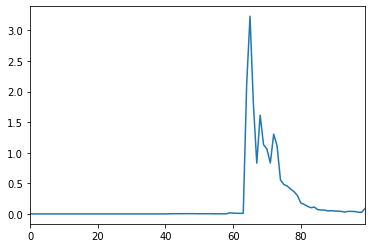

In [75]:
phistory['pl'].plot()

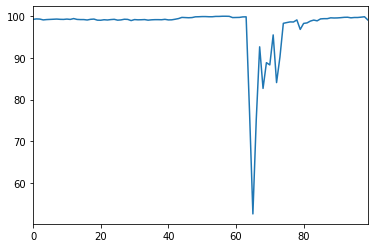

In [76]:
phistory['pa'].plot()

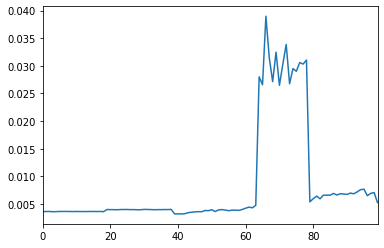

In [77]:
phistory['vl'].plot()

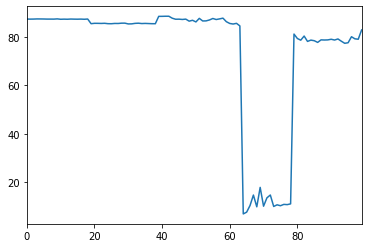

In [78]:
phistory['va'].plot()

In [79]:
torch.save(model.state_dict(), "Pseudo_model.pt")